### Import necessary libraries

In [1]:
import scipy.spatial
import numpy as np
import random
import cv2
import math
import time
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

### Utility functions

In [2]:

def compute_color_probabilities(pixels, palette):
    distances = scipy.spatial.distance.cdist(pixels, palette)
    maxima = np.amax(distances, axis=1)

    distances = maxima[:, None] - distances
    summ = np.sum(distances, 1)
    distances /= summ[:, None]
    return distances

def get_color_from_prob(probabilities, palette, rand=False):
    probs = np.argsort(probabilities)
    i = probs[-1]
    if rand:
        r = random.uniform(0,1)
        if r<=0.1: i = probs[random.randint(max(0, probabilities.shape[0] - 3), probabilities.shape[0] - 1)]
    return palette[i]

def randomized_grid(h, w, scale):
    assert (scale > 0)

    r = scale//2

    grid = []
    for i in range(0, h, scale):
        for j in range(0, w, scale):
            y = random.randint(-r, r) + i
            x = random.randint(-r, r) + j

            grid.append((y % h, x % w))

    random.shuffle(grid)
    return grid


def limit_size(img, max_x, max_y=0):
    if max_x == 0:
        return img

    if max_y == 0:
        max_y = max_x

    ratio = min(1.0, float(max_x) / img.shape[1], float(max_y) / img.shape[0])

    if ratio != 1.0:
        shape = (int(img.shape[1] * ratio), int(img.shape[0] * ratio))
        return cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    else:
        return img

def get_color_palette(img, n=10, scale=200):
    # scale down the image to speedup kmeans
    img = limit_size(img, scale)

    clt = KMeans(n_clusters=n)
    clt.fit(img.reshape(-1, 3))

    return clt.cluster_centers_

def complement(colors):
    return 255 - colors

### Pointlism function

In [3]:
def create_pointlism_art(image_path, primary_colors, save_path, rand=False):
    
    start_time = time.time()
    
    img = cv2.imread(image_path)
    
    radius_width = int(math.ceil(max(img.shape) / 1000))
    print("Radius width: %d" % radius_width)

    palette = get_color_palette(img,primary_colors)
    complements = complement(palette)
    palette = np.vstack((palette,complements))
    print("Color Palette Computed")
    
    print("Drawing image...")
    
    canvas = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    canvas[:,:] = (255,255,255)

    grid = randomized_grid(img.shape[0], img.shape[1], scale=3)

    pixel_colors = np.array([img[x[0], x[1]] for x in grid])
    
    color_probabilities = compute_color_probabilities(pixel_colors, palette)

    for i, (y, x) in enumerate(grid):
        color = get_color_from_prob(color_probabilities[i], palette, rand=rand)
        cv2.ellipse(canvas, (x, y), (radius_width, radius_width), 0, 0, 360, color, -1, cv2.LINE_AA)

    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    cv2.imwrite(save_path, canvas)
    
    print ("Total Time taken: %d seconds" % round(time.time() - start_time, 2))

### Sample run

Radius width: 2
Color Palette Computed
Drawing image...
Total Time taken: 7 seconds


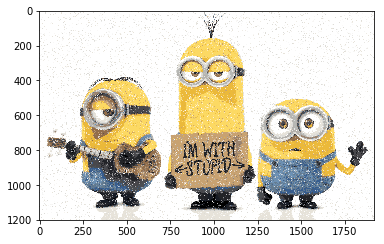

In [7]:
create_pointlism_art('./images/input/minion_gang.jpg', 10, './images/output/minion_gang_rand_out.png', rand=True)